In [74]:
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from src import main, plotting, analysis, io_utils
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.transforms as mtransforms
from scipy import stats

In [3]:
df = main.main()

/data/Work/plot-tilt-stats/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Work/plot-tilt-stats/src/io_utils.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 9.92915533 15.04399737 18.9722507  ... 34.334142   34.95878496
 35.07788068]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['da']>= df['cond1'], 'gamma'] = 180*np.arccos((df.R+df.a)*(1-df.da)/df.R)/np.pi


7982
8040
8052
8056
8088
8122
8130
8171
8226
8404
8552
8589
8628
8649
8699
8851
8968
9063
9139
9308
9368
9396
9417
9574
9660
9678
9710
9884
10130
10137
10311
10391
10971
10987
11007
total ARs = 108


In [4]:
DFx2=df.assign(frac=lambda x: x.alpha-x.alphab)
DFx2=DFx2.assign(t_mean=lambda x: round(10*x.t_norm)/10)

In [46]:
DFx2.keys()

Index(['mag', 'da', 'alpha', 'a', 'R', 'N0', 'axf', 'xc', 'yc', 'alphab',
       'sar', 'lead', 'flux', 'fluxp', 'fluxn', 'fint', 'lat', 'AR', 'spt',
       'rot', 'rotb', 'cond1', 'gamma', 'sepax', 'stp', 'rot_cum', 'rotb_cum',
       't_norm', 'frac', 't_mean'],
      dtype='object')

# SOME PLOTS

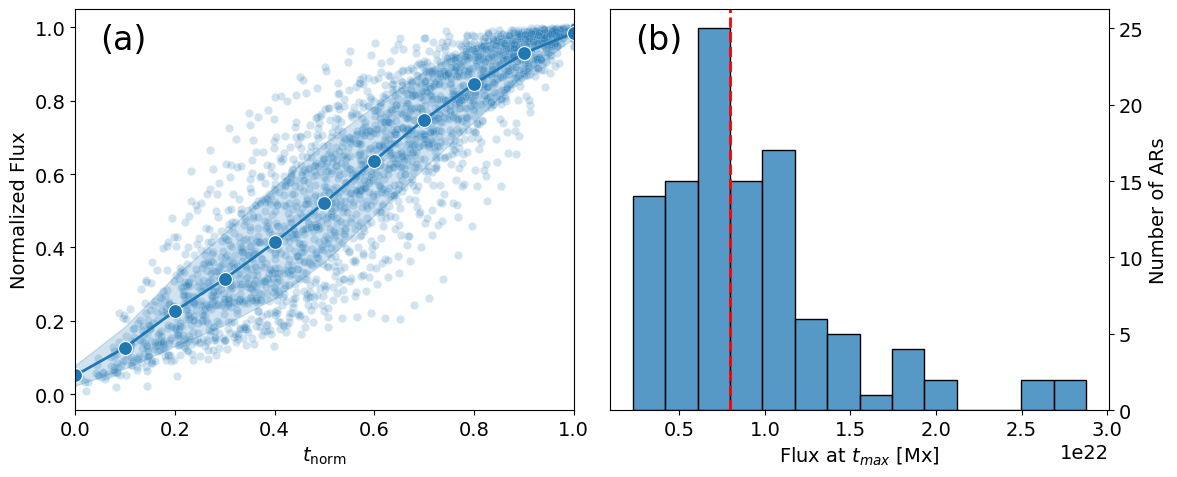

In [72]:
'''
This plot shows the normalized flux vs normalized time for all active regions (ARs).
The flux is normalized by the maximum flux of each AR, and the time is normalized to 1
by the time of maximum flux. The plot includes scatter points for each data point.

'''



f,ax=plt.subplots(1,2,figsize=(12,5))

f,ax1=plotting.plot_single(DFx2,'fint',title='',scatter=True,fig=f,ax=ax[0])
ax1.set_ylabel('Normalized Flux',fontsize=14)
ax1.set_xlabel(r'$t_\mathrm{norm}$',fontsize=14)
ax1.set_xlim(0,1)
ax1.legend().remove()

dfm=DFx2[DFx2.t_mean==1].groupby('AR').mean().reset_index()

arshigh=dfm[dfm.flux>=dfm.flux.median()].AR.unique()
arslow=dfm[dfm.flux<dfm.flux.median()].AR.unique()

#sns.scatterplot(data=DFx2[DFx2.AR.isin(arshigh)],x='t_norm',y='fint',color='tab:orange',alpha=0.3,ax=ax1)

ax1.legend().remove()

ax2=ax[1]
sns.histplot(data=DFx2[DFx2.t_mean==1].groupby('AR').mean().reset_index(),x='flux',ax=ax2)
ax2.axvline(DFx2[DFx2.t_mean==1].groupby('AR').mean().reset_index().flux.median(),color='red',linestyle='--',linewidth=2,
            label=f'Median Flux: {DFx2[DFx2.t_mean==1].groupby("AR").mean().reset_index().flux.median():.2e} Mx')

ax2.set_ylabel('Number of ARs',fontsize=14)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xlabel('Flux at $t_{max}$ [Mx]',fontsize=14)

ax1.text(0.05,0.9,'(a)',transform=ax1.transAxes,fontsize=24)
ax2.text(0.05,0.9,'(b)',transform=ax2.transAxes,fontsize=24)

f.tight_layout()
f.savefig('../figures/flux-all.pdf',dpi=300)

63
22
10
6


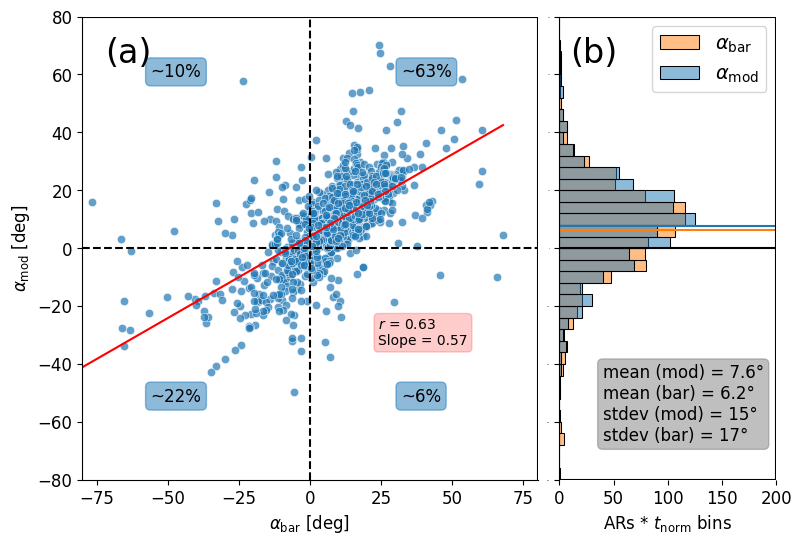

In [107]:
db=DFx2[DFx2.t_mean<=1].groupby(['AR','t_mean']).mean().reset_index()
# 
# 
#  Jointplot de seaborn con histograma extendido en marg_y


g = sns.jointplot(
    data=db,
    x='alphab',
    y='alpha',
    kind='scatter',
    alpha=0.7,
    marginal_kws={'bins': 30,'binrange':(-80,80), 'fill': True},
    ratio=2,height=8,space=0.1)

g.set_axis_labels(r'$\alpha_\mathrm{bar}$ [deg]',r'$\alpha_\mathrm{mod}$ [deg]', fontsize=12)

g.ax_marg_x.set_visible(False)
#g.ax_marg_y.set_visible(False)
g.ax_marg_x.clear()
g.ax_marg_y.clear()
g.ax_marg_x.set_xlabel('X axis label')
g.ax_marg_y.set_ylabel('Y axis label')
g.ax_joint.tick_params(axis='both', labelsize=12)

#g.ax_marg_y.tick_params(axis='y', labelsize=12)

hist=sns.histplot(data=pd.melt(db,id_vars=['t_norm','lat','AR','fint','mag','flux'],value_vars=['alpha','alphab']),y='value',
                  hue='variable',
             palette=['tab:blue','tab:orange'],
             alpha=0.5,ax=g.ax_marg_y,binrange=(-80,80),bins=40)

# Linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(db['alphab'], db['alpha'])

# Add linear fit line
x_fit = np.linspace(db['alphab'].min(), db['alphab'].max(), 100)
y_fit = slope * x_fit + intercept
g.ax_joint.plot(x_fit, y_fit, color='red', label=f'Fit: y={slope:.2f}x+{intercept:.2f}')

# Annotate with correlation coefficient and slope
g.ax_joint.text(
    0.65, 0.35,
    f'$r$ = {r_value:.2f}\nSlope = {slope:.2f}',
    transform=g.ax_joint.transAxes,
    fontsize=10,
    verticalalignment='top',
    bbox=dict(boxstyle="round", alpha=0.2, color='red')
)

#g.ax_marg_y.legend()
g.ax_marg_y.legend(title='',labels=[r'$\alpha_\mathrm{bar}$',r'$\alpha_\mathrm{mod}$'],loc='upper right')
handles,labels=hist.get_legend_handles_labels()
#hist.legend(handles=handles,labels=labels,title=r'$t_{norm}$')
handles,labels=hist.get_legend_handles_labels()
g.ax_marg_y.set_ylabel('')
#
g.ax_marg_y.tick_params(axis='y', labelsize=10)  # Set y-ticklabel fontsize
g.ax_marg_y.tick_params(axis='x', labelsize=10)  # Set x-ticklabel fontsize (if needed)

g.ax_marg_y.axhline(0,color='black')

g.ax_marg_y.axhline(db.alpha.mean(),color='tab:blue')
g.ax_marg_y.axhline(db.alphab.mean(),color='tab:orange')

g.ax_joint.axvline(0,color='black',linestyle='dashed')
g.ax_joint.axhline(0,color='black',linestyle='dashed')
g.ax_joint.set_ylim(-80, 80)
g.ax_joint.set_xlim(-80, 80)

g.ax_marg_y.text(
    0.2, 0.25,
    f'mean (mod) = {db.alpha.mean():.1f}°\nmean (bar) = {db.alphab.mean():.1f}°\nstdev (mod) = {db.alpha.std():.0f}°\nstdev (bar) = {db.alphab.std():.0f}°',
    transform=g.ax_marg_y.transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", alpha=0.5, color='gray')
)

g.ax_marg_y.set_xlim(0,200)

g.ax_joint.plot([-80,80],[80,80],color='black')
g.ax_joint.plot([80,80],[-80,80],color='black')
g.ax_marg_y.plot([0,200],[-80,-80],color='black')
g.ax_marg_y.plot([0,200],[80,80],color='black')
g.ax_marg_y.plot([200,200],[-80,80],color='black')
g.ax_marg_y.tick_params(axis='y', labelsize=0)
g.ax_marg_y.tick_params(axis='x', labelsize=12)
g.ax_marg_y.set_xlabel(r'ARs * $t_\mathrm{norm}$ bins',fontsize=12)

aa=db.alpha.values
ab=db.alphab.values



print(round(100*sum((aa>0)*(ab>0))/len(aa)))
print(round(100*sum((aa<0)*(ab<0))/len(aa)))
print(round(100*sum((aa>0)*(ab<0))/len(aa)))
print(round(100*sum((aa<0)*(ab>0))/len(aa)))

g.ax_joint.text(0.7,0.9,f'~{round(100*sum((aa>0)*(ab>0))/len(aa))}%',transform=g.ax_joint.transAxes,
                fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", alpha=0.5, color='tab:blue'))
g.ax_joint.text(0.15,0.9,f'~{round(100*sum((aa>0)*(ab<0))/len(aa))}%',transform=g.ax_joint.transAxes,
                fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", alpha=0.5, color='tab:blue'))
g.ax_joint.text(0.7,0.2,f'~{round(100*sum((aa<0)*(ab>0))/len(aa))}%',transform=g.ax_joint.transAxes,
                fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", alpha=0.5, color='tab:blue'))
g.ax_joint.text(0.15,0.2,f'~{round(100*sum((aa<0)*(ab<0))/len(aa))}%',transform=g.ax_joint.transAxes,
                fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", alpha=0.5, color='tab:blue'))


g.ax_joint.text(0.05,0.9,'(a)',transform=g.ax_joint.transAxes,fontsize=24)
g.ax_marg_y.text(0.05,0.9,'(b)',transform=g.ax_marg_y.transAxes,fontsize=24)

g.savefig('../figures/alpha-alpha.pdf',dpi=300)


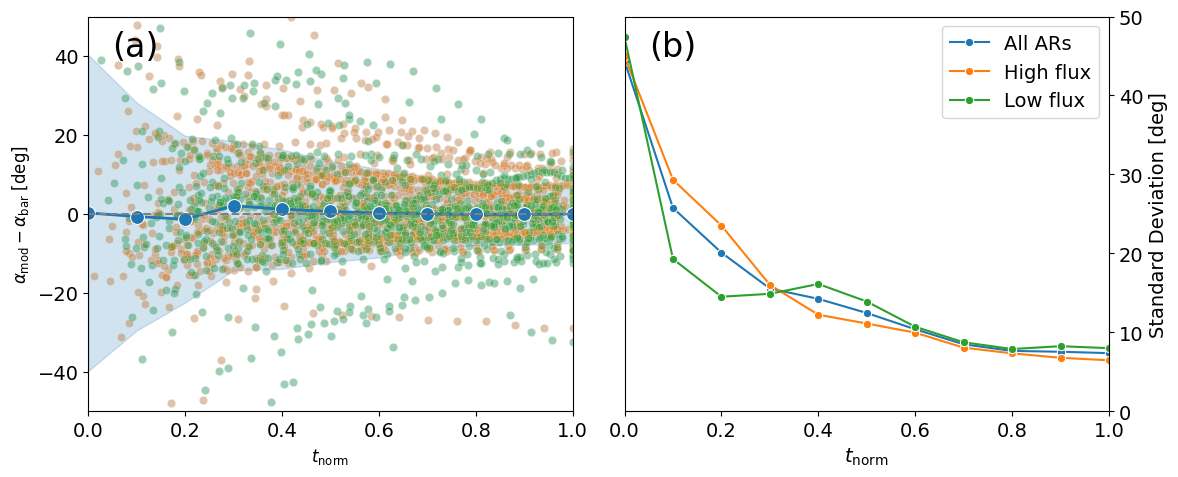

In [126]:
'''
plot showing the difference between the modeled alpha and barycenter alpha 
as a function of normalized time for all active regions (ARs).
Solid line represents the median difference at each normalized time.
The shaded-area plot represents the standard deviation of the difference at each normalized time,
with scatter points for individual data points. Solid dashed line at y=0 for reference.
'''
f,ax=plt.subplots(1,2,figsize=(12,5))

dfm=DFx2[DFx2.t_mean==1].groupby('AR').mean().reset_index()

arshigh=dfm[dfm.flux>=dfm.flux.median()].AR.unique()
arslow=dfm[dfm.flux<dfm.flux.median()].AR.unique()

f,ax1=plotting.plot_single(DFx2,'frac',title='',scatter=True,fig=f,ax=ax[0],estim='median')

sns.scatterplot(DFx2[DFx2.AR.isin(arshigh)],x='t_norm',y='frac',color='tab:orange',alpha=0.3,ax=ax1,label='High Flux ARs')
sns.scatterplot(DFx2[DFx2.AR.isin(arslow)],x='t_norm',y='frac',color='tab:green',alpha=0.3,ax=ax1,label='Low Flux ARs')

ax1.set_ylabel(r'$\alpha_\mathrm{mod} - \alpha_\mathrm{bar}$ [deg]')
ax1.set_xlabel(r'$t_\mathrm{norm}$')
ax1.set_xlim(0,1)
ax1.set_ylim(-50,50)
ax1.axhline(0,color='gray',ls='--')
ax1.legend().remove()

ax2=ax[1]
sns.lineplot(DFx2.groupby(['t_mean']).std().reset_index(),x='t_mean',y='frac',marker='o',ax=ax2,label='All ARs')
sns.lineplot(DFx2[DFx2.AR.isin(arshigh)].groupby(['t_mean']).std().reset_index(),x='t_mean',y='frac',
             marker='o',color='tab:orange',ax=ax2,label='High flux')
sns.lineplot(DFx2[DFx2.AR.isin(arslow)].groupby(['t_mean']).std().reset_index(),x='t_mean',y='frac',
             marker='o',color='tab:green',ax=ax2,label='Low flux')

ax2.set_ylim(0,50)

ax2.legend()

ax2.set_ylabel('Standard Deviation [deg]',fontsize=14)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xlabel(r'$t_\mathrm{norm}$',fontsize=14)

ax1.text(0.05,0.9,'(a)',transform=ax1.transAxes,fontsize=24)
ax2.text(0.05,0.9,'(b)',transform=ax2.transAxes,fontsize=24)
ax2.set_xlim(0,1)

f.tight_layout()


f.savefig('../figures/alpha-err.pdf',dpi=300)

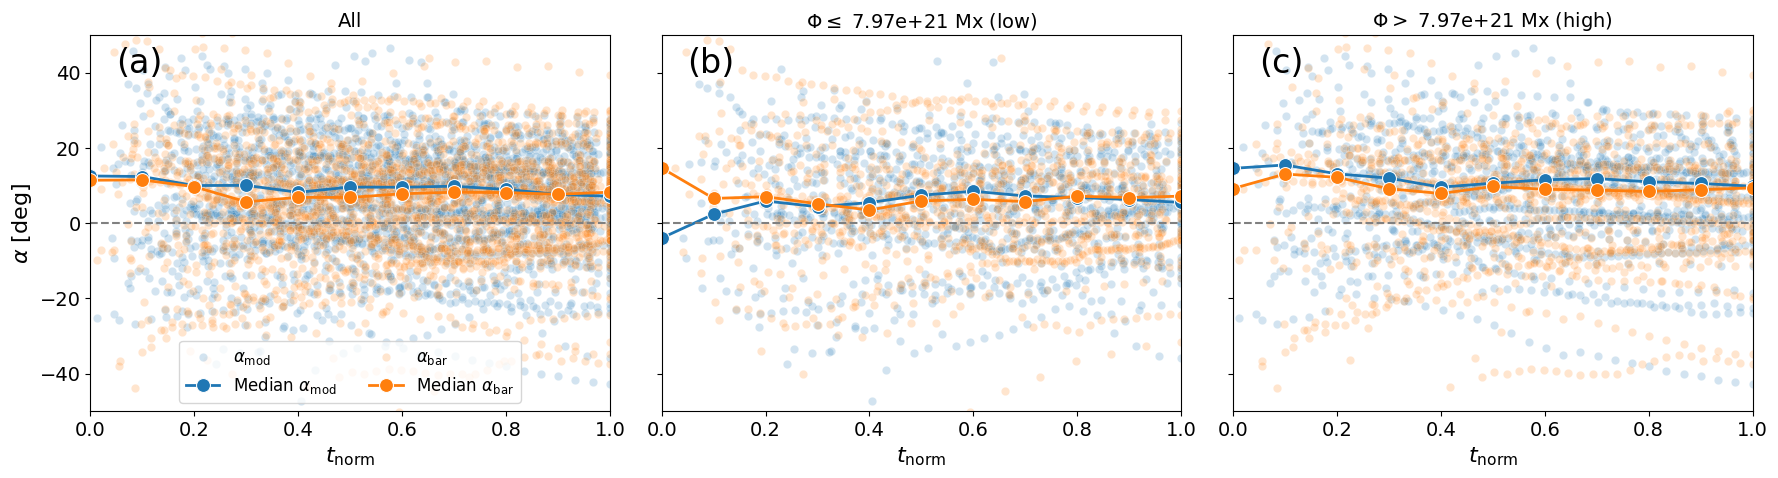

In [101]:
'''
plot of alpha vs normalized time for all ARs, and for low and high flux subsets.
Solid lines represent the median alpha at each normalized time for both modeled and barycenter methods.
Scatter points represent individual data points. Solid dashed line at y=0 for reference.

'''



f,ax=plt.subplots(1,3,figsize=(18,5),sharey=True)



db=DFx2[DFx2.t_mean==1].groupby('AR').mean().reset_index()

arslowf=db[db.flux <= db.flux.median()].AR.unique()
arshighf=db[db.flux > db.flux.median()].AR.unique()


for db1,ax1,title in zip([DFx2,DFx2[DFx2.AR.isin(arslowf)],DFx2[DFx2.AR.isin(arshighf)]],ax,
                        ['All',rf'$\Phi \leq $ {db.flux.median():.2e} Mx (low)',rf'$\Phi > $ {db.flux.median():.2e} Mx (high)']):


    f,ax2=plotting.plot_single(db1,'alpha',title='',ax=ax1,fig=f,scatter=True,estim='median',
                               error=None,err_kws={'alpha':1},color='tab:blue',ls='-')
    f,ax2=plotting.plot_single(db1,'alphab',title='',ax=ax1,fig=f,color='tab:orange',scatter=True,
                               estim='median',
                               error=None,err_kws={'alpha':1},ls='-')
    ax1.set_ylabel(r'$\alpha$ [deg]',fontsize=16)
    ax1.set_xlabel(r'$t_\mathrm{norm}$',fontsize=16)
    ax1.set_title(title)
    ax1.legend().remove()
    ax1.set_xlim(0,1)
    ax1.set_ylim(-50,50)
    ax1.axhline(0,color='gray',ls='--')

    

h,l=ax[0].get_legend_handles_labels()
ax[0].legend(ncols=2,fontsize=12,handles=h,labels=[r'$\alpha_\mathrm{mod}$',r'Median $\alpha_\mathrm{mod}$',r'$\alpha_\mathrm{bar}$',r'Median $\alpha_\mathrm{bar}$'],loc='lower center')

for i,ax1 in enumerate(ax):
    ax1.text(0.05,0.9,f'({chr(97+i)})',transform=ax1.transAxes,fontsize=24)

f.tight_layout()
f.savefig('../figures/alpha-vs-t_norm.pdf',dpi=300)

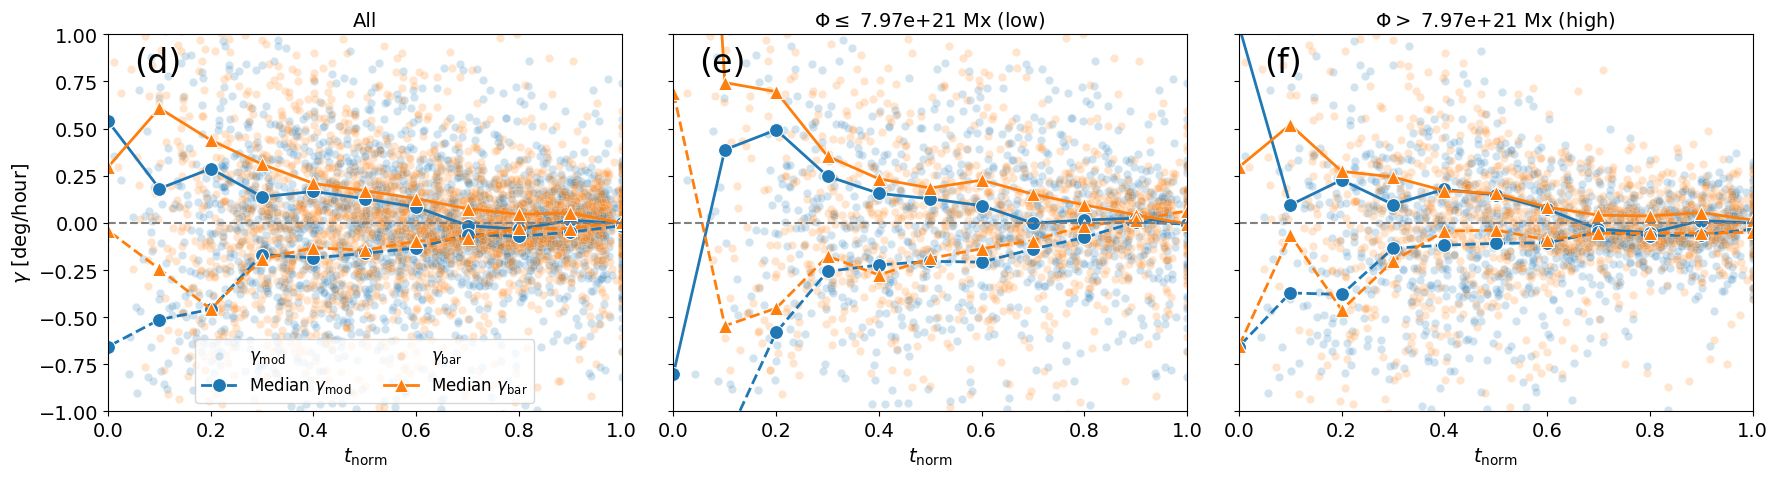

In [106]:
'''
Plot of ARs rotations over time, separated by positive and negative cumulative rotation.
Solid lines represent the median alpha at each normalized time for both modeled and barycenter methods.
scatter points represent individual data points. Solid dashed line at y=0 for reference.
Each panel shows all ARs, low flux ARs, and high flux ARs respectively.

'''



f,ax=plt.subplots(1,3,figsize=(18,5),sharey=True)



db=DFx2[DFx2.t_mean==1].groupby('AR').mean().reset_index()

arslowf=db[db.flux <= db.flux.median()].AR.unique()
arshighf=db[db.flux > db.flux.median()].AR.unique()


for db1,ax1,title in zip([DFx2,DFx2[DFx2.AR.isin(arslowf)],DFx2[DFx2.AR.isin(arshighf)]],ax,
                        ['All',rf'$\Phi \leq $ {db.flux.median():.2e} Mx (low)',rf'$\Phi > $ {db.flux.median():.2e} Mx (high)']):

    dfm=db1.groupby('AR').mean().reset_index()

    arsp=dfm[dfm.rot_cum>0].AR.values
    arsn=dfm[dfm.rot_cum<0].AR.values

    # plot rot_cum in blue with circle marker and solid line
    f1,ax1=plotting.plot_single(db1[db1.AR.isin(arsp)],'rot',title='',marker='o',
                            color='tab:blue',error=None,estim='median',
                            err_kws={'alpha':1},ax=ax1,fig=f,scatter=True)


    # plot rot_cum in blue with circle marker and solid line
    f1,ax1=plotting.plot_single(db1[db1.AR.isin(arsn)],'rot',title='',marker='o'
                            ,color='tab:blue',error=None,estim='median',
                            err_kws={'alpha':1},ax=ax1,fig=f,scatter=True,ls='--')

    arsp=dfm[dfm.rotb_cum>0].AR.values
    arsn=dfm[dfm.rotb_cum<0].AR.values

    # plot rotb_cum in orange with triangle marker and dashed line
    f1,ax1=plotting.plot_single(db1[db1.AR.isin(arsp)],'rotb',title='',
                            ax=ax1,fig=f,marker='^',color='tab:orange',estim='median'
                            ,error=None,err_kws={'alpha':1},scatter=True)



    f1,ax1=plotting.plot_single(db1[db1.AR.isin(arsn)],'rotb',title='',
                            ax=ax1,fig=f,marker='^',color='tab:orange',estim='median',
                            error=None,err_kws={'alpha':1},scatter=True,ls='--')

    ax1.legend().remove()
    ax1.set_ylabel(r'$\gamma$ [deg/hour]',fontsize=14)
    ax1.set_xlabel(r'$t_\mathrm{norm}$',fontsize=14)
    ax1.set_xlim(0,1)
    ax1.set_ylim(-1,1)
    ax1.axhline(0,color='gray',ls='--')
    ax1.set_title(title)

h,l=ax[0].get_legend_handles_labels()
ax[0].legend(ncols=2,fontsize=12,handles=[*h[0:2],*h[4:6]],
             labels=[r'$\gamma_\mathrm{mod}$',r'Median $\gamma_\mathrm{mod}$',r'$\gamma_\mathrm{bar}$',r'Median $\gamma_\mathrm{bar}$'],
             loc='lower center')

for i,ax1 in enumerate(ax):
    ax1.text(0.05,0.9,f'({chr(100+i)})',transform=ax1.transAxes,fontsize=24)

f.tight_layout()
f.savefig('../figures/gamma-vs-t_norm.pdf',dpi=300)

In [104]:
h

<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\c'
<>:33: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\c'
<>:33: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\c'
<>:36: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_183968/3003576647.py:33: SyntaxWarning: invalid escape sequence '\m'
  ax1.text(100,15,f'$\mu$: {db1.rot_cum.mean():.1f}$^\circ$\n$\sigma$: {db1.rot_cum.std():.1f}$^\circ$\nskew: {db1.rot_cum.skew():.2f}',
/tmp/ipykernel_183968/3003576647.py:33: SyntaxWarning: invalid escape sequence '\c'
  ax1.text(100,15,f'$\mu$: {db1.rot_cum.mean():.1f}$^\circ$\n$\sigma$: {db1.rot_cum

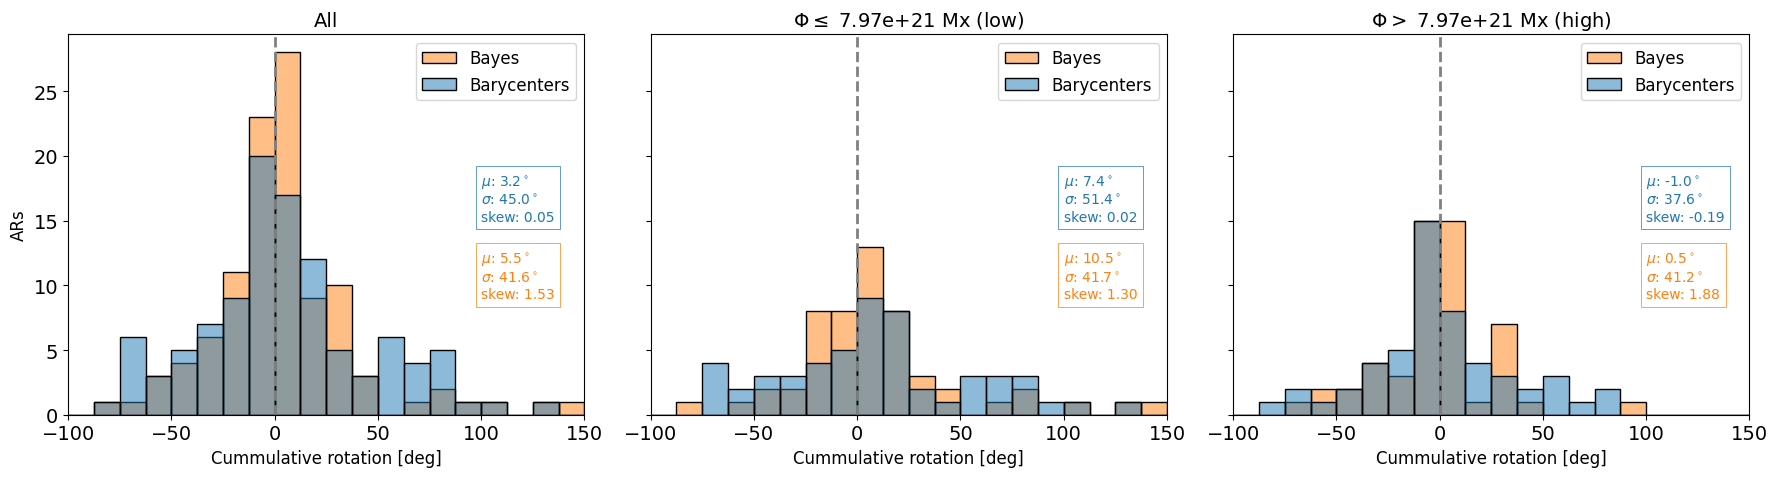

In [11]:
'''
plot of cumulative rotation for all ARs, and for low and high flux subsets.
Histograms comparing the cumulative rotation calculated using the modeled alpha and barycenter alpha methods.
The cumulative rotation is calculated at the time of maximum flux (t_mean=1).

'''


f,ax=plt.subplots(1,3,figsize=(18,5),sharey=True)



db=DFx2[DFx2.t_mean==1].groupby('AR').mean().reset_index()

arslowf=db[db.flux <= db.flux.median()].AR.unique()
arshighf=db[db.flux > db.flux.median()].AR.unique()


for db1,ax1,title in zip([db,db[db.AR.isin(arslowf)],db[db.AR.isin(arshighf)]],ax,
                        ['All',rf'$\Phi \leq $ {db.flux.median():.2e} Mx (low)',rf'$\Phi > $ {db.flux.median():.2e} Mx (high)']):
    sns.histplot(data=pd.melt(db1,
                            value_vars=['rot_cum','rotb_cum']),x='value',hue='variable',fill=True,ax=ax1,binrange=(-100,150),bins=20)

    ax1.set_xlabel(r'Cummulative rotation [deg]')
    ax1.set_ylabel('ARs')
    ax1.set_title(title)
    ax1.set_xlim(-100,150)
    

    ax1.legend(title='',labels=['Bayes','Barycenters'],fontsize=12)
    ax1.axvline(0,color='gray',linestyle='--',linewidth=2)

    ax1.text(100,15,f'$\mu$: {db1.rot_cum.mean():.1f}$^\circ$\n$\sigma$: {db1.rot_cum.std():.1f}$^\circ$\nskew: {db1.rot_cum.skew():.2f}',
            color='tab:blue',fontsize=10,
            bbox=dict(facecolor='white', alpha=1,linewidth=0.5,edgecolor='tab:blue'))
    ax1.text(100,9,f'$\mu$: {db1.rotb_cum.mean():.1f}$^\circ$\n$\sigma$: {db1.rotb_cum.std():.1f}$^\circ$\nskew: {db1.rotb_cum.skew():.2f}',
            color='tab:orange',fontsize=10,
            bbox=dict(facecolor='white', alpha=1,linewidth=0.5,edgecolor='tab:orange'))

f.tight_layout()
f.savefig('../figures/hist_cumrot.pdf',dpi=300)

<>:51: SyntaxWarning: invalid escape sequence '\m'
<>:51: SyntaxWarning: invalid escape sequence '\c'
<>:51: SyntaxWarning: invalid escape sequence '\c'
<>:54: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\c'
<>:54: SyntaxWarning: invalid escape sequence '\c'
<>:51: SyntaxWarning: invalid escape sequence '\m'
<>:51: SyntaxWarning: invalid escape sequence '\c'
<>:51: SyntaxWarning: invalid escape sequence '\c'
<>:54: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\c'
<>:54: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_183968/2445005860.py:51: SyntaxWarning: invalid escape sequence '\m'
  ax1.text(100,15,f'$\mu$: {db1.frac_rot.mean():.1f}$^\circ$\n$\sigma$: {db1.frac_rot.std():.1f}$^\circ$\nskew: {db1.frac_rot.skew():.2f}',
/tmp/ipykernel_183968/2445005860.py:51: SyntaxWarning: invalid escape sequence '\c'
  ax1.text(100,15,f'$\mu$: {db1.frac_rot.mean():.1f}$^\circ$\n$\sigma$: {db1.fra

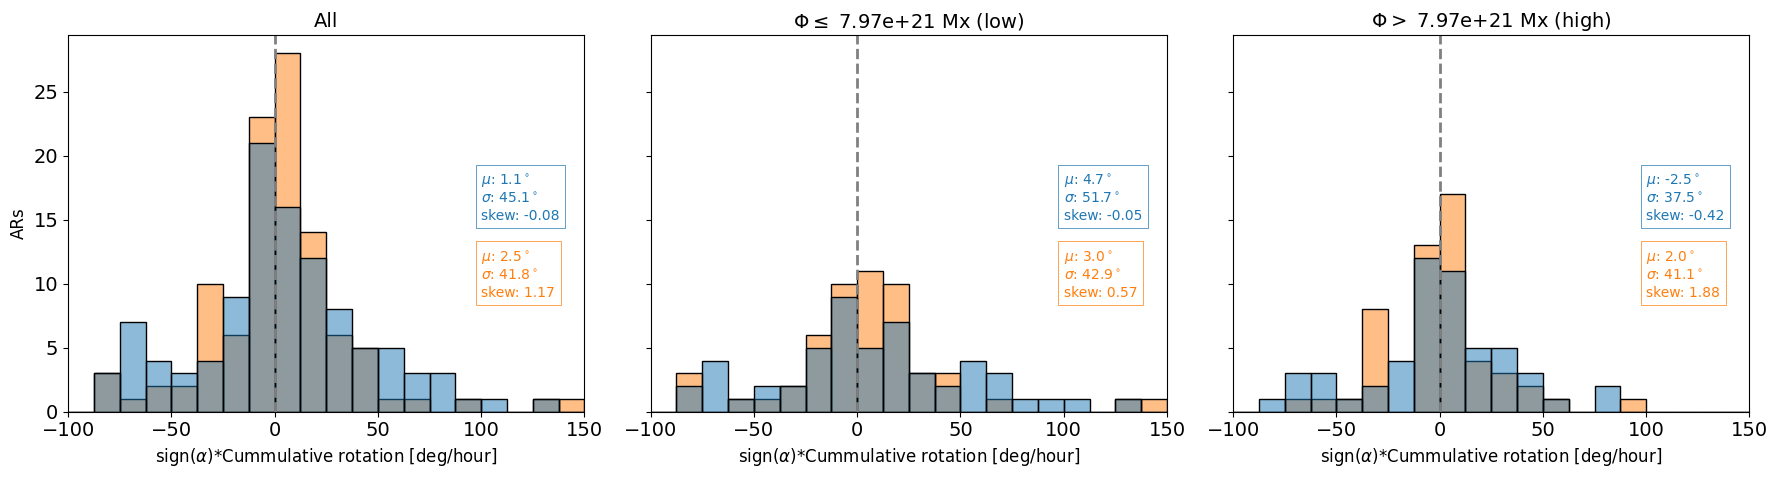

In [12]:
'''
Este plot muestra histogramas de la rotación acumulada (gamma)
en el momento del flujo magnético máximo de las regiones activas (ARs).
Se divide en tres subplots: todos los ARs, ARs con flujo bajo y ARs con flujo alto.
Se calculan estadísticas como la media, desviación estándar y sesgo
para cada grupo y se muestran en el gráfico. Los valores extremos fuera del rango
de -200 a 200 se excluyen para una mejor visualización, ya que estos provienen de ARs
con valores muy pequeños de tilt al final de la emergencia que generan fracciones muy grandes.
'''


f,ax=plt.subplots(1,3,figsize=(18,5),sharey=True)



db=DFx2[DFx2.t_mean==1].groupby('AR').mean().reset_index()

db['frac_rot'] = np.sign(db['alpha'])*db['rot_cum']
db['frac_rotb'] = np.sign(db['alphab'])*db['rotb_cum']

# Crear máscaras para valores entre -5 y 5
mask_rot = (db['frac_rot'].between(-200, 200))
mask_rotb = (db['frac_rotb'].between(-200, 200))

# Aplicar las máscaras y reemplazar valores fuera del rango con NaN
db.loc[~mask_rot, 'frac_rot'] = np.nan
db.loc[~mask_rotb, 'frac_rotb'] = np.nan

# Alternativamente, si quieres mantener solo las filas que cumplen ambas condiciones:
db = db[mask_rot & mask_rotb]

arslowf=db[db.flux <= db.flux.median()].AR.unique()
arshighf=db[db.flux > db.flux.median()].AR.unique()


for db1,ax1,title in zip([db,db[db.AR.isin(arslowf)],db[db.AR.isin(arshighf)]],ax,
                        ['All',rf'$\Phi \leq $ {db.flux.median():.2e} Mx (low)',rf'$\Phi > $ {db.flux.median():.2e} Mx (high)']):
    sns.histplot(data=pd.melt(db1,
                            value_vars=['frac_rot','frac_rotb']),x='value',hue='variable',fill=True,ax=ax1,bins=20,binrange=(-100,150))

    ax1.set_xlabel(r'sign($\alpha$)*Cummulative rotation [deg/hour]')
    ax1.set_ylabel('ARs')
    ax1.set_title(title)
    ax1.set_xlim(-100,150)
    ax1.legend().remove()
    

    #ax1.legend(title='',labels=['Bayes','Barycenters'],fontsize=12)
    ax1.axvline(0,color='gray',linestyle='--',linewidth=2)

    ax1.text(100,15,f'$\mu$: {db1.frac_rot.mean():.1f}$^\circ$\n$\sigma$: {db1.frac_rot.std():.1f}$^\circ$\nskew: {db1.frac_rot.skew():.2f}',
            color='tab:blue',fontsize=10,
            bbox=dict(facecolor='white', alpha=1,linewidth=0.5,edgecolor='tab:blue'))
    ax1.text(100,9,f'$\mu$: {db1.frac_rotb.mean():.1f}$^\circ$\n$\sigma$: {db1.frac_rotb.std():.1f}$^\circ$\nskew: {db1.frac_rotb.skew():.2f}',
            color='tab:orange',fontsize=10,
            bbox=dict(facecolor='white', alpha=1,linewidth=0.5,edgecolor='tab:orange'))

f.tight_layout()
f.savefig('../figures/hist_cumrot2.pdf',dpi=300)


<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\c'
<>:32: SyntaxWarning: invalid escape sequence '\c'
<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\c'
<>:35: SyntaxWarning: invalid escape sequence '\c'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\c'
<>:32: SyntaxWarning: invalid escape sequence '\c'
<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\c'
<>:35: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_183968/1911394526.py:32: SyntaxWarning: invalid escape sequence '\m'
  ax1.text(100,10,f'$\mu$: {db1.rot_cum.mean():.1f}$^\circ$\n$\sigma$: {db1.rot_cum.std():.1f}$^\circ$\nskew: {db1.rot_cum.skew():.2f}',
/tmp/ipykernel_183968/1911394526.py:32: SyntaxWarning: invalid escape sequence '\c'
  ax1.text(100,10,f'$\mu$: {db1.rot_cum.mean():.1f}$^\circ$\n$\sigma$: {db1.rot_cum

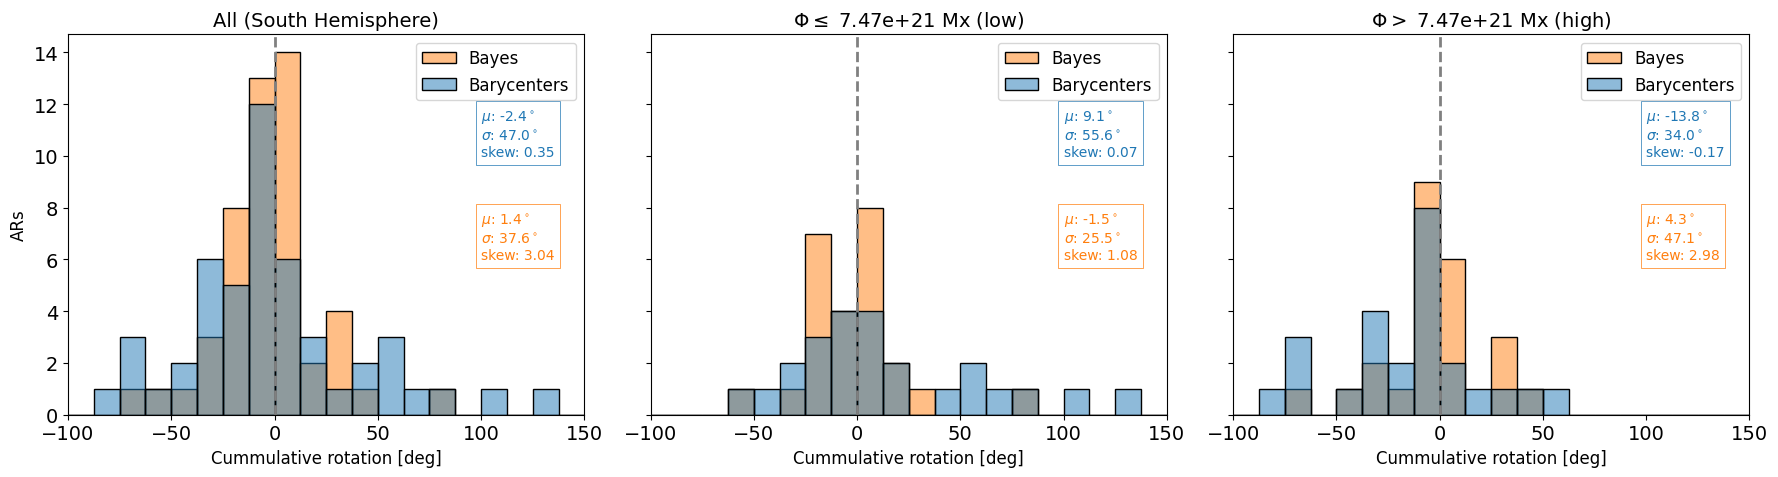

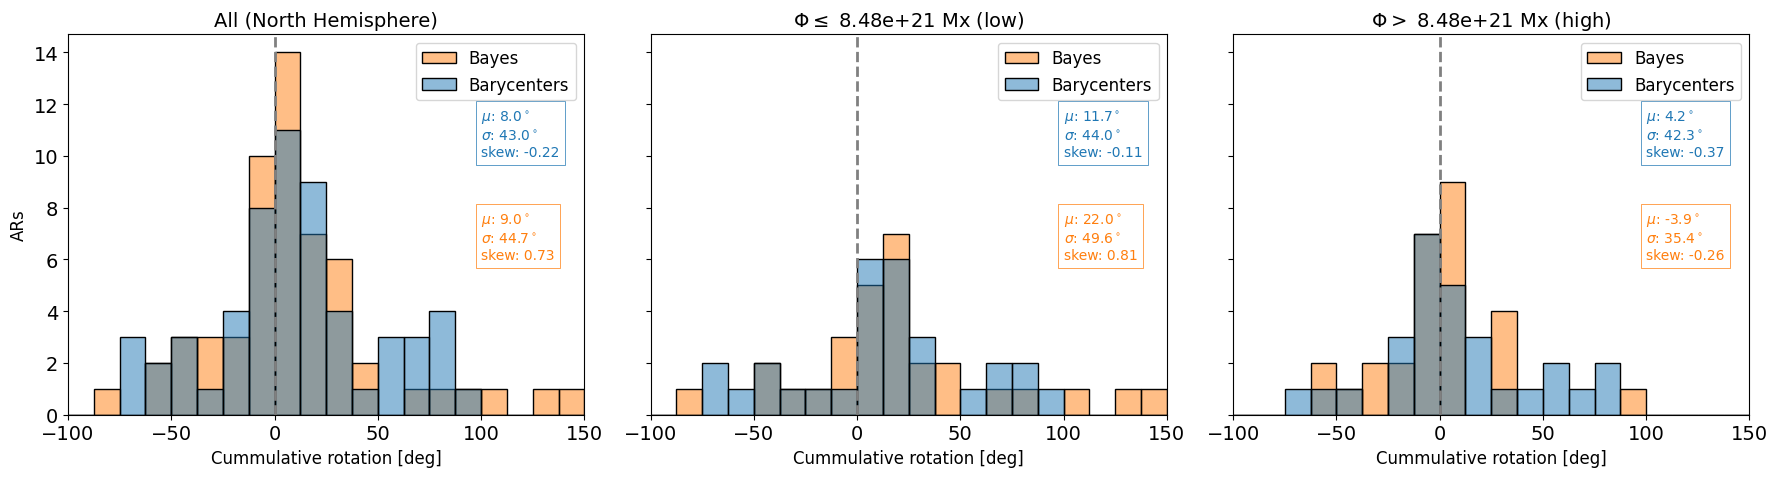

In [14]:
'''
plot of cumulative rotation for all ARs, and for low and high flux subsets.
Histograms comparing the cumulative rotation calculated using the modeled alpha and barycenter alpha methods.
The cumulative rotation is calculated at the time of maximum flux (t_mean=1).

'''


for a,hem in [(-1,'South Hemisphere'),(1,'North Hemisphere')]:

    f,ax=plt.subplots(1,3,figsize=(18,5),sharey=True)
    db=DFx2[(DFx2.t_mean==1) & (DFx2.lat*a > 0)].groupby('AR').mean().reset_index()

    arslowf=db[db.flux <= db.flux.median()].AR.unique()
    arshighf=db[db.flux > db.flux.median()].AR.unique()


    for db1,ax1,title in zip([db,db[db.AR.isin(arslowf)],db[db.AR.isin(arshighf)]],ax,
                            [f'All ({hem})',rf'$\Phi \leq $ {db.flux.median():.2e} Mx (low)',rf'$\Phi > $ {db.flux.median():.2e} Mx (high)']):
        sns.histplot(data=pd.melt(db1,
                                value_vars=['rot_cum','rotb_cum']),x='value',hue='variable',fill=True,ax=ax1,binrange=(-100,150),bins=20)

        ax1.set_xlabel(r'Cummulative rotation [deg]')
        ax1.set_ylabel('ARs')
        ax1.set_title(title)
        ax1.set_xlim(-100,150)
        

        ax1.legend(title='',labels=['Bayes','Barycenters'],fontsize=12)
        ax1.axvline(0,color='gray',linestyle='--',linewidth=2)

        ax1.text(100,10,f'$\mu$: {db1.rot_cum.mean():.1f}$^\circ$\n$\sigma$: {db1.rot_cum.std():.1f}$^\circ$\nskew: {db1.rot_cum.skew():.2f}',
                color='tab:blue',fontsize=10,
                bbox=dict(facecolor='white', alpha=1,linewidth=0.5,edgecolor='tab:blue'))
        ax1.text(100,6,f'$\mu$: {db1.rotb_cum.mean():.1f}$^\circ$\n$\sigma$: {db1.rotb_cum.std():.1f}$^\circ$\nskew: {db1.rotb_cum.skew():.2f}',
                color='tab:orange',fontsize=10,
                bbox=dict(facecolor='white', alpha=1,linewidth=0.5,edgecolor='tab:orange'))

    f.tight_layout()
#    f.savefig('../figures/hist_cumrot.pdf',dpi=300)

$\rho_{mod}$: -0.28$
$\rho_{bar}$: -0.49$


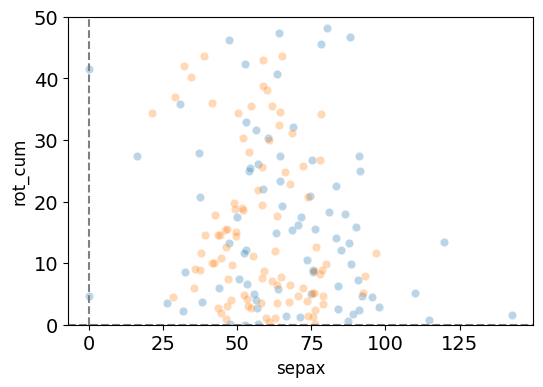

In [40]:
db=DFx2[DFx2.t_mean==1].groupby('AR').mean().reset_index().abs()

sns.scatterplot(data=db,x='sepax',y='rot_cum',alpha=0.3)
sns.scatterplot(data=db,x='sar',y='rotb_cum',alpha=0.3)

plt.axvline(0,linestyle='--',color='gray')
plt.axhline(0,linestyle='--',color='gray')

plt.ylim(0,50)
print(rf'$\rho_{{mod}}$: {db["rot"].corr(db["sepax"]):.2f}$')
print(rf'$\rho_{{bar}}$: {db["rotb"].corr(db["sar"]):.2f}$')
#plt.text(30,20,rf'$\rho$: {db["alpha"].corr(db["rot"]):.2f}',color='tab:blue')
#plt.text(30,10,rf'$\rho$: {db["alphab"].corr(db["rotb"]):.2f}',color='tab:orange')

(-2.0, 2.0)

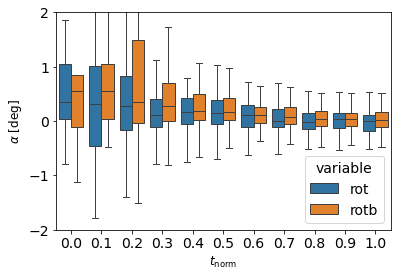

In [9]:
mdf=pd.melt(DFx2,id_vars=['t_norm','t_mean','lat','AR','mag','flux'],value_vars=['rot','rotb'])
dfm=df.groupby('AR').mean().reset_index()

mdf=mdf[(mdf.t_norm>0) & (mdf.t_norm<1.05)]

arsp1=dfm[dfm.rot_cum>0].AR.values
arsp2=dfm[dfm.rotb_cum>0].AR.values
arsn1=dfm[dfm.rot_cum<0].AR.values
arsn2=dfm[dfm.rotb_cum<0].AR.values

# crear máscaras alineadas con el DataFrame completo
mask_pos_rot  = (mdf['variable']=='rot')  & (mdf['AR'].isin(arsp1))
mask_pos_rotb = (mdf['variable']=='rotb') & (mdf['AR'].isin(arsp2))
mdf_pos = mdf[mask_pos_rot | mask_pos_rotb]

mask_neg_rot  = (mdf['variable']=='rot')  & (mdf['AR'].isin(arsn1))
mask_neg_rotb = (mdf['variable']=='rotb') & (mdf['AR'].isin(arsn2))
mdf_neg = mdf[mask_neg_rot | mask_neg_rotb]

f,ax=plt.subplots()
#sns.lineplot(data=mdf,x='t_mean',y='value',estimator='mean',hue='variable',marker='o',errorbar='sd',err_style='bars')
sns.boxplot(data=mdf_pos,x='t_mean',y='value',hue='variable',ax=ax,fliersize=False)
#sns.boxplot(data=mdf_neg,x='t_mean',y='value',hue='variable',ax=ax,fliersize=False)
ax.set_ylabel(r'$\alpha$ [deg]')
ax.set_xlabel(r'$t_\mathrm{norm}$')
ax.set_ylim(-2,2)

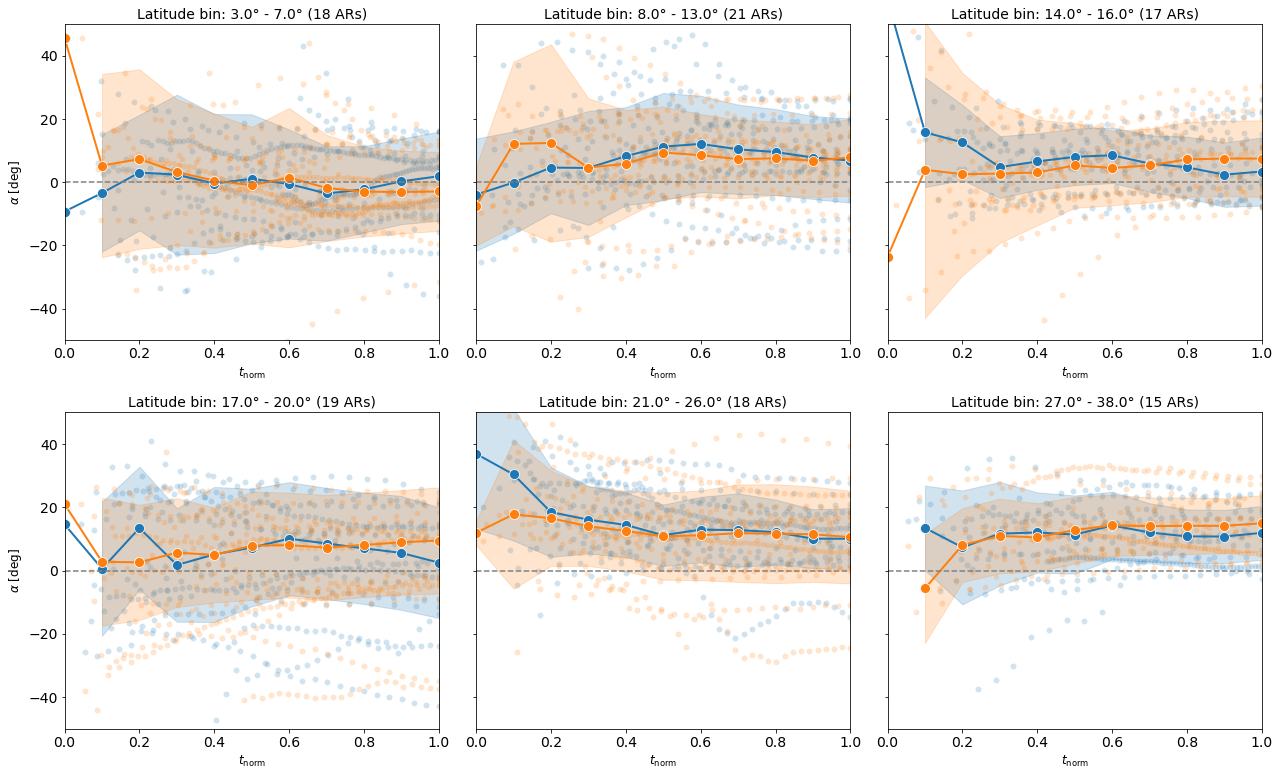

In [108]:
'''
Plot of alpha vs normalized time for all ARs, separated by latitude bins.
Solid lines represent the median alpha at each normalized time for both modeled and barycenter methods.
scatter points represent individual data points. Solid dashed line at y=0 for reference.
Each panel shows a different latitude bin. Shaded area represents the standard deviation at each time.
'''


DFx2['lat']=np.abs(DFx2['lat'])

DFx2['lat_bin'] = pd.qcut(DFx2['lat'], q=6,labels=False)

f,ax=plt.subplots(2,3,figsize=(18,11),sharey=True)

for (i,lat_bin),ax1 in zip(enumerate(np.sort(DFx2.lat_bin.unique())),ax.flatten()):
    db1=DFx2[DFx2['lat_bin']==lat_bin]
    nARs=len(db1.AR.unique())

    binrange=db1.lat.min(),db1.lat.max()

    f1,ax1=plotting.plot_single(db1,'alpha',title='',ax=ax1,fig=f,scatter=True,estim='median',
                               error='band',err_kws={'alpha':1},color='tab:blue',ls='-')
    f1,ax1=plotting.plot_single(db1,'alphab',title='',ax=ax1,fig=f,color='tab:orange',scatter=True,
                               estim='median',
                               error='band',err_kws={'alpha':1},ls='-')
    ax1.set_ylabel(r'$\alpha$ [deg]')
    ax1.set_xlabel(r'$t_\mathrm{norm}$')
    ax1.set_title(f'Latitude bin: {binrange[0]:.1f}° - {binrange[1]:.1f}° ({nARs} ARs)')
    ax1.legend().remove()
    ax1.set_xlim(0,1)
    ax1.set_ylim(-50,50)
    ax1.axhline(0,color='gray',ls='--')
f.tight_layout()
f.savefig('../figures/alpha-vs-t_norm-by-lat.pdf',dpi=300)

<ipython-input-107-0bd48d0487ad>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db['t_bin'] = pd.qcut(db['t_norm'], q=4,labels=False)


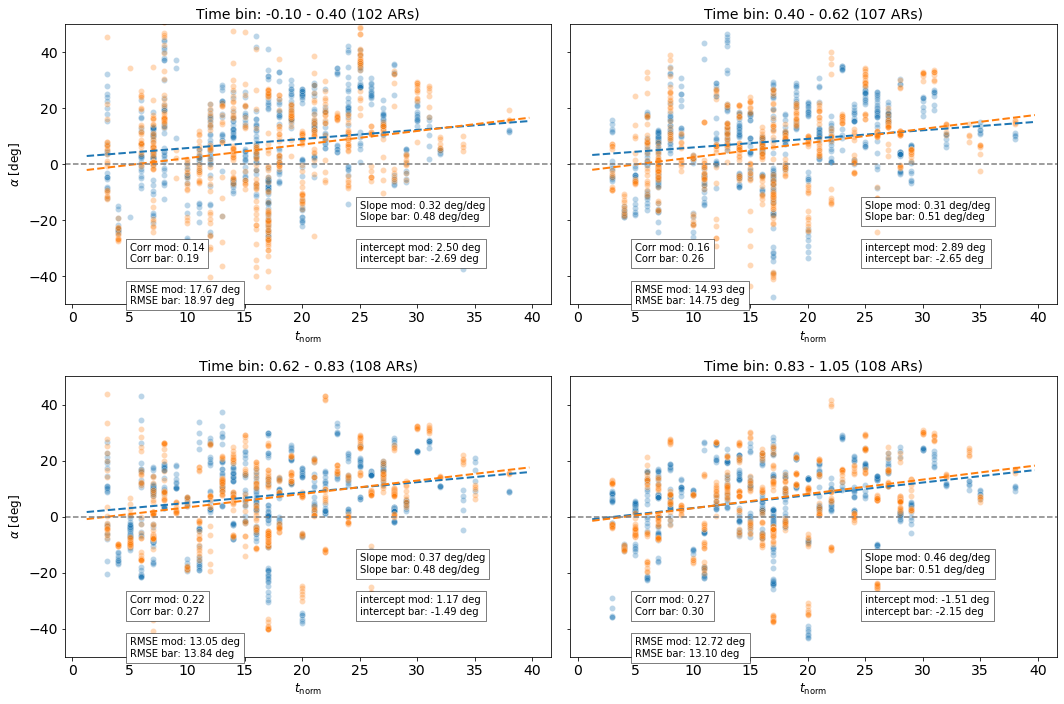

In [107]:
'''
Plot of alpha vs latitude for all ARs, separated by normalized time bins.
Dashed lines represent linear fits for both modeled and barycenter methods.
scatter points represent individual data points. Solid dashed line at y=0 for reference.
Each panel shows a different normalized time bin.


'''



DFx2['lat']=np.abs(DFx2['lat'])


db=DFx2[DFx2.t_mean<=1]


db['t_bin'] = pd.qcut(db['t_norm'], q=4,labels=False)

f,ax=plt.subplots(2,2,figsize=(15,10),sharey=True)

for (i,t_bin),ax1 in zip(enumerate(np.sort(db.t_bin.unique())),ax.flatten()):
    db1=db[db['t_bin']==t_bin]
    nARs=len(db1.AR.unique())

    binrange=db1.t_norm.min(),db1.t_norm.max()

    sns.scatterplot(data=db1,x='lat',y='alpha',color='tab:blue',alpha=0.3,label=r'$\alpha_\mathrm{mod}$',ax=ax1)
    sns.scatterplot(data=db1,x='lat',y='alphab',color='tab:orange',alpha=0.3,label=r'$\alpha_\mathrm{bar}$',ax=ax1)
    db2=db1.groupby('AR').median().reset_index()
    #sns.scatterplot(data=db2,x='lat',y='alpha',color='tab:blue',s=100,edgecolor='black',label=r'Median $\alpha_\mathrm{mod}$',ax=ax1)
    #sns.scatterplot(data=db2,x='lat',y='alphab',color='tab:orange',s=100,edgecolor='black',label=r'Median $\alpha_\mathrm{bar}$',ax=ax1)

    slope, intercept = np.polyfit(db2['lat'], db2['alpha'], 1)
    x_vals = np.array(ax1.get_xlim())
    y_vals = intercept + slope * x_vals
    ax1.plot(x_vals, y_vals, color='tab:blue', linestyle='--',linewidth=2, label='Fit $\alpha_\mathrm{mod}$')
    slope_b, intercept_b = np.polyfit(db2['lat'], db2['alphab'], 1)
    y_vals_b = intercept_b + slope_b * x_vals
    ax1.plot(x_vals, y_vals_b, color='tab:orange', linestyle='--',linewidth=2, label='Fit $\alpha_\mathrm{bar}$')


    ax1.text(25,-20,
            f'Slope mod: {slope:.2f} deg/deg\nSlope bar: {slope_b:.2f} deg/deg',
            fontsize=10,
            bbox=dict(facecolor='white', alpha=1,linewidth=0.5,edgecolor='black'))
    
    corr=db2[['lat','alpha']].corr().iloc[0,1]
    corr_b=db2[['lat','alphab']].corr().iloc[0,1]
    ax1.text(5,-35, f'Corr mod: {corr:.2f}\nCorr bar: {corr_b:.2f}',
            fontsize=10, bbox=dict(facecolor='white', alpha=1,linewidth=0.5,edgecolor='black'))    

    rmse = ((db2['alpha'] - (slope * db2['lat'] + intercept)) ** 2).mean() ** 0.5
    rmse_b = ((db2['alphab'] - (slope_b * db2['lat'] + intercept_b)) ** 2).mean() ** 0.5
    ax1.text(5,-50, f'RMSE mod: {rmse:.2f} deg\nRMSE bar: {rmse_b:.2f} deg',
            fontsize=10, bbox=dict(facecolor='white', alpha=1,linewidth=0.5,edgecolor='black'))
    
    ax1.text(25,-35, f'intercept mod: {intercept:.2f} deg\nintercept bar: {intercept_b:.2f} deg ',
            fontsize=10, bbox=dict(facecolor='white', alpha=1,linewidth=0.5,edgecolor='black'))
    ax1.set_ylabel(r'$\alpha$ [deg]')
    ax1.set_xlabel(r'$t_\mathrm{norm}$')
    ax1.set_title(f'Time bin: {binrange[0]:.2f} - {binrange[1]:.2f} ({nARs} ARs)')
    ax1.legend().remove()
    #ax1.set_xlim(0,1)
    ax1.set_ylim(-50,50)
    ax1.axhline(0,color='gray',ls='--')

f.tight_layout()
f.savefig('../figures/alpha-vs-lat-by-tnorm.pdf',dpi=300)



# Discarded plots

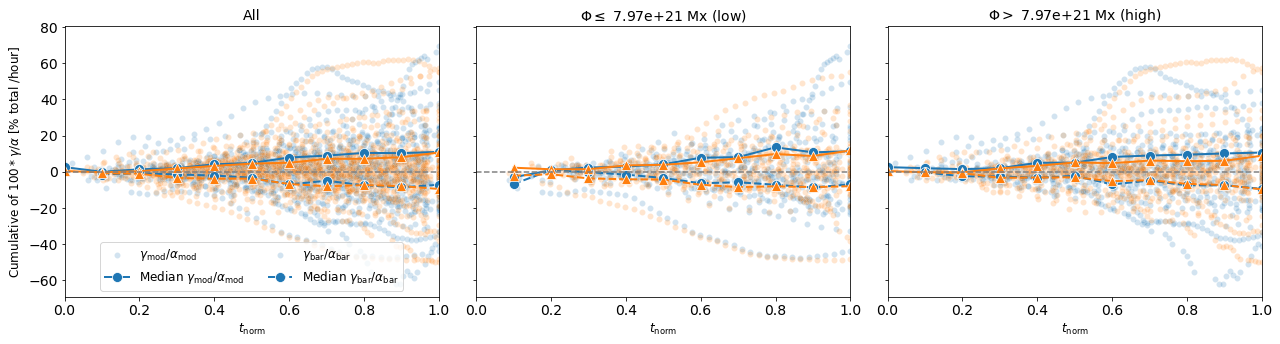

In [12]:
import numpy as np

db=DFx2[DFx2.t_mean==1].groupby('AR').mean().reset_index()

dfa=pd.merge(db,DFx2,on='AR',suffixes=('_max',''))

dfa['frac_rot'] = dfa['rot']/dfa['alpha_max']*100
dfa['frac_rotb'] = dfa['rotb']/dfa['alphab_max']*100

# Crear máscaras para valores entre -5 y 5
mask_rot = (dfa['frac_rot'].between(-5, 5))
mask_rotb = (dfa['frac_rotb'].between(-5, 5))

# Aplicar las máscaras y reemplazar valores fuera del rango con NaN
dfa.loc[~mask_rot, 'frac_rot'] = np.nan
dfa.loc[~mask_rotb, 'frac_rotb'] = np.nan

# Alternativamente, si quieres mantener solo las filas que cumplen ambas condiciones:
dfa = dfa[mask_rot & mask_rotb]

dfa['frac_rot']=dfa.groupby('AR').frac_rot.cumsum()
dfa['frac_rotb']=dfa.groupby('AR').frac_rotb.cumsum()

f,ax=plt.subplots(1,3,figsize=(18,5),sharey=True)

arslowf=db[db.flux <= db.flux.median()].AR.unique()
arshighf=db[db.flux > db.flux.median()].AR.unique()


for db1,ax1,title in zip([dfa,dfa[dfa.AR.isin(arslowf)],dfa[dfa.AR.isin(arshighf)]],ax,
                        ['All',rf'$\Phi \leq $ {db.flux.median():.2e} Mx (low)',rf'$\Phi > $ {db.flux.median():.2e} Mx (high)']):

    dfm=db1.groupby('AR').mean().reset_index()

    arsp=dfm[dfm.frac_rot>0].AR.values
    arsn=dfm[dfm.frac_rot<0].AR.values

    # plot rot_cum in blue with circle marker and solid line
    f1,ax1=plotting.plot_single(db1[db1.AR.isin(arsp)],'frac_rot',title='',marker='o',
                            color='tab:blue',error=None,estim='median',
                            err_kws={'alpha':1},ax=ax1,fig=f,scatter=True)


    # plot rot_cum in blue with circle marker and solid line
    f1,ax1=plotting.plot_single(db1[db1.AR.isin(arsn)].reset_index(),'frac_rot',title='',marker='o'
                            ,color='tab:blue',error=None,estim='median',
                            err_kws={'alpha':1},ax=ax1,fig=f,scatter=True,ls='--')

    arsp=dfm[dfm.frac_rotb>0].AR.values
    arsn=dfm[dfm.frac_rotb<0].AR.values

    # plot rotb_cum in orange with triangle marker and dashed line
    f1,ax1=plotting.plot_single(db1[db1.AR.isin(arsp)],'frac_rotb',title='',
                            ax=ax1,fig=f,marker='^',color='tab:orange',estim='median'
                            ,error=None,err_kws={'alpha':1},scatter=True)



    f1,ax1=plotting.plot_single(db1[db1.AR.isin(arsn)],'frac_rotb',title='',
                            ax=ax1,fig=f,marker='^',color='tab:orange',estim='median',
                            error=None,err_kws={'alpha':1},scatter=True,ls='--')

    ax1.legend().remove()
    ax1.set_ylabel(r'Cumulative of $100*\gamma/\alpha$ [% total /hour]')
    ax1.set_xlabel(r'$t_\mathrm{norm}$')
    ax1.set_xlim(0,1)
    #ax1.set_ylim(-20,20)
    ax1.axhline(0,color='gray',ls='--')
    ax1.set_title(title)

h,l=ax[0].get_legend_handles_labels()
ax[0].legend(ncols=2,fontsize=12,handles=h,
             labels=[r'$\gamma_\mathrm{mod}/\alpha_\mathrm{mod}$',
                     r'Median $\gamma_\mathrm{mod}/\alpha_\mathrm{mod}$',
                     r'$\gamma_\mathrm{bar}/\alpha_\mathrm{bar}$',
                     r'Median $\gamma_\mathrm{bar}/\alpha_\mathrm{bar}$'],
             loc='lower center')
f.tight_layout()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


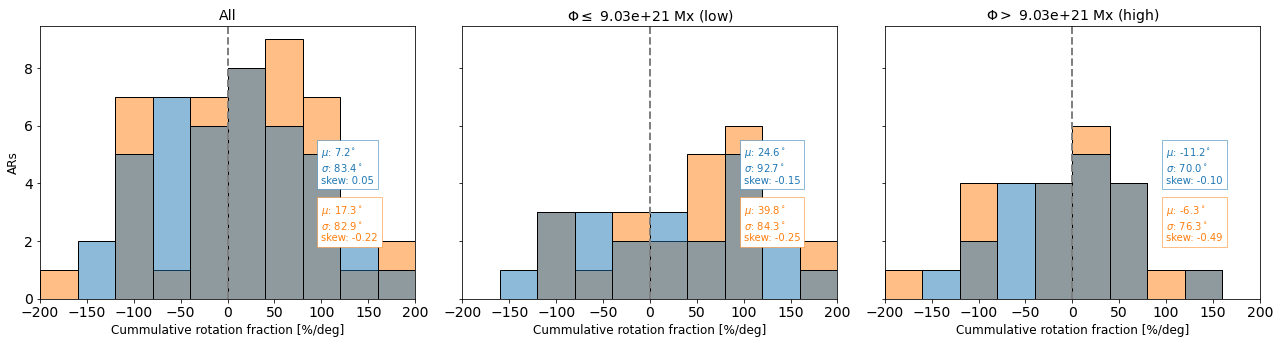

In [ ]:
'''
Este plot muestra histogramas de la fracción acumulativa de rotación (gamma/alpha)
en función del momento del flujo magnético total de las regiones activas (ARs).
Se divide en tres subplots: todos los ARs, ARs con flujo bajo y ARs con flujo alto.
Se calculan estadísticas como la media, desviación estándar y sesgo
para cada grupo y se muestran en el gráfico. Los valores extremos fuera del rango
de -200 a 200 se excluyen para una mejor visualización, ya que estos provienen de ARs
con valores muy pequeños de tilt al final de la emergencia que generan fracciones muy grandes.

'''

f,ax=plt.subplots(1,3,figsize=(18,5),sharey=True)



db=DFx2[DFx2.t_mean==1].groupby('AR').mean().reset_index()

db['frac_rot'] = 100*db['rot_cum']/db['alpha']
db['frac_rotb'] = 100*db['rotb_cum']/db['alphab']

# Crear máscaras para valores entre -5 y 5
mask_rot = (db['frac_rot'].between(-200, 200))
mask_rotb = (db['frac_rotb'].between(-200, 200))

# Aplicar las máscaras y reemplazar valores fuera del rango con NaN
db.loc[~mask_rot, 'frac_rot'] = np.nan
db.loc[~mask_rotb, 'frac_rotb'] = np.nan

# Alternativamente, si quieres mantener solo las filas que cumplen ambas condiciones:
db = db[mask_rot & mask_rotb]

arslowf=db[db.flux <= db.flux.median()].AR.unique()
arshighf=db[db.flux > db.flux.median()].AR.unique()


for db1,ax1,title in zip([db,db[db.AR.isin(arslowf)],db[db.AR.isin(arshighf)]],ax,
                        ['All',rf'$\Phi \leq $ {db.flux.median():.2e} Mx (low)',rf'$\Phi > $ {db.flux.median():.2e} Mx (high)']):
    sns.histplot(data=pd.melt(db1,
                            value_vars=['frac_rot','frac_rotb']),x='value',hue='variable',fill=True,ax=ax1,bins=10,binrange=(-200,200))

    ax1.set_xlabel(r'Cummulative rotation fraction [%/deg]')
    ax1.set_ylabel('ARs')
    ax1.set_title(title)
    ax1.set_xlim(-200,200)
    ax1.legend().remove()
    

    #ax1.legend(title='',labels=['Bayes','Barycenters'],fontsize=12)
    ax1.axvline(0,color='gray',linestyle='--',linewidth=2)

    ax1.text(100,4,f'$\mu$: {db1.frac_rot.mean():.1f}$^\circ$\n$\sigma$: {db1.frac_rot.std():.1f}$^\circ$\nskew: {db1.frac_rot.skew():.2f}',
            color='tab:blue',fontsize=10,
            bbox=dict(facecolor='white', alpha=1,linewidth=0.5,edgecolor='tab:blue'))
    ax1.text(100,2,f'$\mu$: {db1.frac_rotb.mean():.1f}$^\circ$\n$\sigma$: {db1.frac_rotb.std():.1f}$^\circ$\nskew: {db1.frac_rotb.skew():.2f}',
            color='tab:orange',fontsize=10,
            bbox=dict(facecolor='white', alpha=1,linewidth=0.5,edgecolor='tab:orange'))

f.tight_layout()


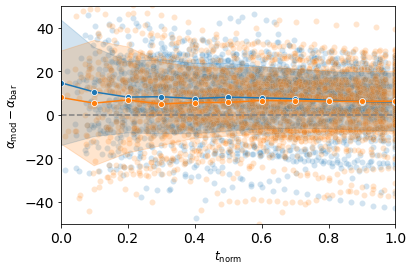

: 

: 

In [ ]:
f,ax=plotting.plot_comparison(DFx2,'alpha','alphab',title='',all=True)
ax.set_ylabel(r'$\alpha_\mathrm{mod} - \alpha_\mathrm{bar}$')
ax.set_xlabel(r'$t_\mathrm{norm}$')
ax.set_xlim(0,1)
ax.set_ylim(-50,50)
ax.axhline(0,color='gray',ls='--')

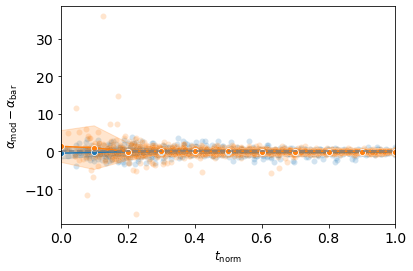

: 

: 

In [ ]:
f,ax=plotting.plot_comparison(DFx2,'rot','rotb',title='',all=True)
ax.set_ylabel(r'$\alpha_\mathrm{mod} - \alpha_\mathrm{bar}$')
ax.set_xlabel(r'$t_\mathrm{norm}$')
ax.set_xlim(0,1)
#ax.set_ylim(-50,50)
ax.axhline(0,color='gray',ls='--')